In [1]:
!pip install transformers==4.28.0
!pip install datasets


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, BertForMaskedLM
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import pipeline
from transformers import AutoModelForMaskedLM,AutoTokenizer
from transformers import DataCollatorForLanguageModeling
from transformers import LineByLineTextDataset
import os
import math

c:\Users\88697\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check version
import transformers
torch.__version__, transformers.__version__

('1.10.0+cu111', '4.28.0')

In [3]:
torch.cuda.is_available()

True

In [5]:
df = pd.read_csv('C:\\Users\\88697\\Desktop\\碩二\\碩二論文雜項\\Sentences_75Agree.txt', encoding= 'unicode_escape')
df

,sentence,label
0,"According to Gran , the company has no plans t...",0
1,With the new production plant the company woul...,1
2,"For the last quarter of 2010 , Componenta 's n...",1
3,"In the third quarter of 2010 , net sales incre...",1
4,Operating profit rose to EUR 13.1 mn from EUR ...,1
...,...,...
3375,Operating result for the 12-month period decre...,2
3376,HELSINKI Thomson Financial - Shares in Cargote...,2
3377,LONDON MarketWatch -- Share prices ended lower...,2
3378,Operating profit fell to EUR 35.4 mn from EUR ...,2


In [4]:
from datasets import load_dataset

from transformers import AutoModel

from transformers import BertTokenizer

from transformers import AutoConfig, AutoModelForSequenceClassification


id2label = {
    "0": "Neutral",
    "1": "Positive",
    "2": "Negative"
  }

label2id = {
    "Neutral": 0,
    "Positive": 1,
    "Negative": 2
  }



model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=3, label2id=label2id, id2label=id2label)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [7]:
list(df.columns)

['sentence', 'label']

In [8]:
df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)
print(df_train.shape, df_test.shape, df_val.shape)

(2737, 2) (338, 2) (305, 2)


In [9]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 338/338 [00:00<00:00, 4995.79 examples/s]


In [5]:
from sklearn.metrics import precision_recall_fscore_support

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.flatten(), predictions.flatten(), average='weighted', zero_division=0)
    return {'accuracy' : accuracy_score(predictions, labels),
         'f1': f1,
         'precision': precision,
         'recall': recall
            }

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                 # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,          # evaluation dataset
        compute_metrics=compute_metrics
)
no_deprecation_warning=True
trainer.train()





































































































                                                

                                          


  4%|▎         | 16/430 [01:24<03:10,  2.18it/s]






{'eval_loss': 0.26253607869148254, 'eval_accuracy': 0.9245901639344263, 'eval_f1': 0.9245901639344263, 'eval_precision': 0.9245901639344263, 'eval_recall': 0.9245901639344263, 'eval_runtime': 1.1983, 'eval_samples_per_second': 254.532, 'eval_steps_per_second': 8.345, 'epoch': 1.0}





































































































                                                

                                           


  4%|▎         | 16/430 [02:01<03:10,  2.18it/s]






{'eval_loss': 0.2947246730327606, 'eval_accuracy': 0.9114754098360656, 'eval_f1': 0.912086521963829, 'eval_precision': 0.9137119980552726, 'eval_recall': 0.9114754098360656, 'eval_runtime': 1.193, 'eval_samples_per_second': 255.658, 'eval_steps_per_second': 8.382, 'epoch': 2.0}







































































































                                                

                                           


  4%|▎         | 16/430 [02:37<03:10,  2.18it/s]






{'eval_loss': 0.2991618812084198, 'eval_accuracy': 0.9180327868852459, 'eval_f1': 0.918031116215934, 'eval_precision': 0.9180858830556846, 'eval_recall': 0.9180327868852459, 'eval_runtime': 1.2139, 'eval_samples_per_second': 251.263, 'eval_steps_per_second': 8.238, 'epoch': 3.0}







































































































                                                

                                           


  4%|▎         | 16/430 [03:18<03:10,  2.18it/s]






{'eval_loss': 0.29191577434539795, 'eval_accuracy': 0.9278688524590164, 'eval_f1': 0.9279528120020029, 'eval_precision': 0.9280633065922567, 'eval_recall': 0.9278688524590164, 'eval_runtime': 1.2055, 'eval_samples_per_second': 253.004, 'eval_steps_per_second': 8.295, 'epoch': 4.0}





































































































                                                

                                           


  4%|▎         | 16/430 [03:54<03:10,  2.18it/s]






{'eval_loss': 0.31214773654937744, 'eval_accuracy': 0.9245901639344263, 'eval_f1': 0.9247266070421823, 'eval_precision': 0.9249534796270065, 'eval_recall': 0.9245901639344263, 'eval_runtime': 1.1691, 'eval_samples_per_second': 260.874, 'eval_steps_per_second': 8.553, 'epoch': 5.0}



                                                

100%|██████████| 430/430 [03:07<00:00,  2.30it/s]

{'train_runtime': 187.1946, 'train_samples_per_second': 73.106, 'train_steps_per_second': 2.297, 'train_loss': 0.11097110482149346, 'epoch': 5.0}


TrainOutput(global_step=430, training_loss=0.11097110482149346, metrics={'train_runtime': 187.1946, 'train_samples_per_second': 73.106, 'train_steps_per_second': 2.297, 'train_loss': 0.11097110482149346, 'epoch': 5.0})

In [14]:
model.eval()
trainer.predict(dataset_test).metrics








100%|██████████| 11/11 [00:01<00:00,  8.06it/s]


{'test_loss': 0.294540137052536,
 'test_accuracy': 0.9319526627218935,
 'test_f1': 0.9317601899870758,
 'test_precision': 0.9321542771786098,
 'test_recall': 0.9319526627218935,
 'test_runtime': 2.5995,
 'test_samples_per_second': 130.025,
 'test_steps_per_second': 4.232}

In [15]:
trainer.save_model('/content/drive/MyDrive/Colab Notebooks/BERT')

In [6]:
m = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/BERT")
print(m.config.id2label)

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}


In [7]:
bertFP = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/BERT')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [18]:
file_path = 'C:\\Users\\88697\\Downloads\\AINews_label\\1.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# 定義將數字標籤轉換為情緒標籤的函數
def convert_label(numeric_label):
    label_map = {0: 'Neutral', 1: 'Negativ', 2: 'Positive'}
    return label_map[numeric_label]

# 轉換所有相關列的數字標籤
label_columns = ['researcher label', 'ChatGPT label', 'researcher2 label']
for column in label_columns:
    if column in data.columns:
        data[column] = data[column].apply(convert_label)

# 保存更新後的 DataFrame
data.to_csv(file_path, index=False, encoding='ISO-8859-1')

print(data)

  7%|▋         | 32/430 [04:28<55:42,  8.40s/it]


KeyError: 'Neutral'

In [8]:
data = pd.read_csv('C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv', usecols=[1], encoding='ISO-8859-1').values
data2 = pd.read_csv('C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv', encoding='ISO-8859-1', index_col=False)
nlp = pipeline("text-classification", model=bertFP, tokenizer=tokenizer)
lst=[]
for x in range(len(data)):
  string = np.array_str(data[x])
  print(string)
  results = nlp(string)
  print(x+1, results)
  string = ''.join(map(str, results))
  if "Positive" in string:
      p='Positive'
      lst.append(p)
  elif "Negative" in string:
      n='Negative'
      lst.append(n)
  elif "Neutral" in string:
      u='Neutral'
      lst.append(u)
for x in range(len(lst)):
    data2.at[x, 'BERT Label'] = lst[x]
df = pd.DataFrame(data2)
df.to_csv('C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv', index=False)
df

['Dialpad Acquires TalkIQ to Bring Voice-Driven Artificial Intelligence to Business Communications']
1 [{'label': 'Neutral', 'score': 0.9957005381584167}]
['Dialpad, the pure-cloud business communications provider, today announced it has acquired TalkIQ, a leader in real-time speech recognition and artificial intelligence.']
2 [{'label': 'Neutral', 'score': 0.968736469745636}]
["By combining TalkIQ's real-time speech recognition and natural language processing technologies with Dialpad's leading communications solutions, Dialpad will deliver VoiceAI to help business teams capture and learn from conversations as they happen."]
3 [{'label': 'Positive', 'score': 0.9877534508705139}]
['One trillion words are spoken every day on phone calls between U.S. businesses and their customers, and 92 percent of business and customer interactions still happen over the phone.']
4 [{'label': 'Neutral', 'score': 0.9980974793434143}]
['By applying voice intelligence to all external and internal communica

,number,sentence,researcher label,ChatGPT label,researcher2 label,final label,BiLSTM Label,BERT Label,FinBERT Label,FinBERT_FinNews Label,LM Label,FinBERT_AICalls Label
0,1,Dialpad Acquires TalkIQ to Bring Voice-Driven ...,Neutral,Positive,Neutral,NaN,NaN,Neutral,NaN,NaN,NaN,Neutral
1,2,"Dialpad, the pure-cloud business communication...",Neutral,Neutral,Neutral,NaN,NaN,Neutral,NaN,NaN,NaN,Neutral
2,3,By combining TalkIQ's real-time speech recogni...,Neutral,Positive,Neutral,NaN,NaN,Positive,NaN,NaN,NaN,Neutral
3,4,One trillion words are spoken every day on pho...,Neutral,Neutral,Neutral,NaN,NaN,Neutral,NaN,NaN,NaN,Neutral
4,5,By applying voice intelligence to all external...,Neutral,Positive,Positive,NaN,NaN,Positive,NaN,NaN,NaN,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
666,13,Support for four other undisclosed brands are...,Neutral,Neutral,Neutral,NaN,NaN,Neutral,NaN,NaN,NaN,Neutral
667,14,Customer safety and the ability to do more whi...,Neutral,Neutral,Neutral,NaN,NaN,Neutral,NaN,NaN,NaN,Positive
668,15,"On one hand, they want the customer to be abl...",Neutral,Neutral,Neutral,NaN,NaN,Neutral,NaN,NaN,NaN,Neutral
669,16,"Alfia continues, ""By having access to our serv...",Positive,Positive,Positive,NaN,NaN,Neutral,NaN,NaN,NaN,Neutral


In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# 讀取 CSV 檔案
file_path = 'C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# 計算不匹配的次數
mismatches = data['researcher2 label'] != data['BERT Label']
mismatch_count = mismatches.sum()
total_data = data['researcher2 label'] == data['researcher2 label']
data_count = total_data.sum()

# 計算準確率
accuracy = accuracy_score(data['researcher2 label'], data['BERT Label'])
# 計算精確率
precision = precision_score(data['researcher2 label'], data['BERT Label'], average='macro')
# 計算召回率
recall = recall_score(data['researcher2 label'], data['BERT Label'], average='macro')
# 計算 F1 分數
f1 = f1_score(data['researcher2 label'], data['BERT Label'], average='macro')

print(f"Number of data: {data_count}")
print(f"Number of mismatches: {mismatch_count}")
print(f"Accuracy of the model predictions: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Number of data: 671
Number of mismatches: 169
Accuracy of the model predictions: 0.75
Precision: 0.63
Recall: 0.60
F1 Score: 0.61


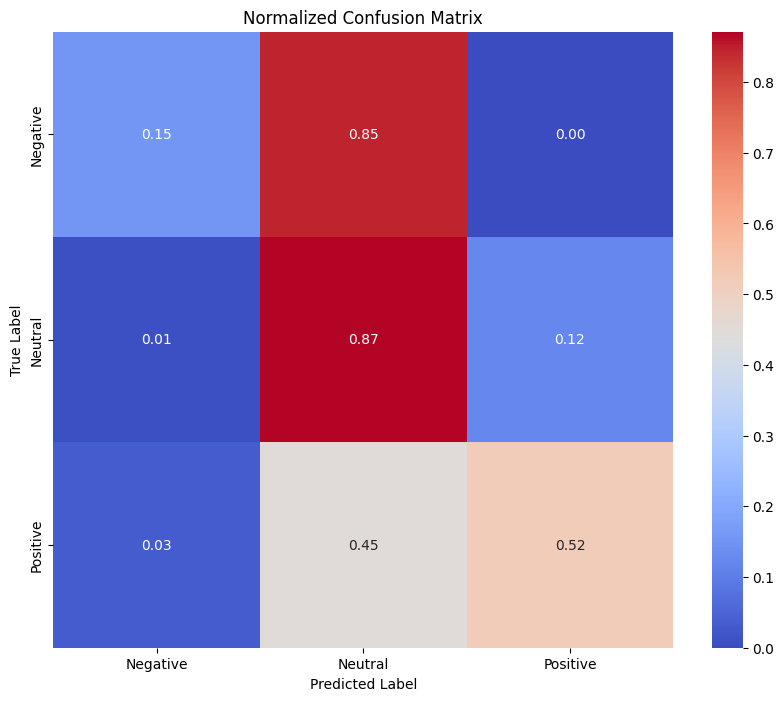

In [21]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取 CSV 檔案
file_path = 'C:\\Users\\88697\\Downloads\\AINews_label\\Total_data.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

# 確定使用正確的標籤列
correct_label_column = 'BERT Label'  # 假設這是正確的模型預測標籤列

# 計算混淆矩陣
conf_matrix = confusion_matrix(data['researcher2 label'], data[correct_label_column], normalize='true')

# 使用 seaborn 繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=sorted(data['researcher2 label'].unique()), yticklabels=sorted(data['researcher2 label'].unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()
